# 🚦 Fuzzy Logic-Based Traffic Light Control System

An intelligent traffic light control system using **Fuzzy Logic** and **Mamdani Inference** to optimize traffic flow at a 4-way intersection.

## 📋 Overview
- **28 Advanced Fuzzy Rules** per direction (112 total rules)
- **Realistic Queue-Based Simulation** using Poisson arrival distribution
- **Performance Comparison**: Fuzzy vs Fixed-Time controllers
- **Comprehensive Metrics**: waiting time, queue length, throughput, fairness index

## 🏗️ System Architecture
```
┌─────────────┐    ┌──────────────┐    ┌─────────────┐    ┌────────────────┐
│   Input     │───▶│Fuzzification │───▶│   Fuzzy     │───▶│Defuzzification │
│   Layer     │    │              │    │   Rules     │    │                │
│ • Density   │    │ Low/Med/High │    │  (Mamdani)  │    │ Green Duration │
│ • Wait Time │    │              │    │  28 Rules   │    │   10-90 sec    │
└─────────────┘    └──────────────┘    └─────────────┘    └────────────────┘
```

## 📦 1. Setup & Installation
Install required dependencies for fuzzy logic and simulation

In [10]:
# Install dependencies (uncomment if running on Google Colab)
!pip install numpy scikit-fuzzy matplotlib pandas scipy networkx -q

# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Dict, List, Optional, Tuple
from dataclasses import dataclass, field
from enum import Enum
import logging
import json

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported successfully!")
print(f"  NumPy version: {np.__version__}")
print(f"  Matplotlib version: {plt.matplotlib.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 13.0 MB/s eta 0:00:00
✓ Libraries imported successfully!
  NumPy version: 2.0.2
  Matplotlib version: 3.10.0


## 🎯 2. Fuzzy Membership Functions
Define membership functions for:
- **Input Variables**: Vehicle Density (0-100), Waiting Time (0-300s)
- **Output Variable**: Green Light Duration (10-90s)

In [11]:
import skfuzzy as fuzz
from skfuzzy import control as ctrl

def create_membership_functions() -> Tuple[Dict[str, ctrl.Antecedent], ctrl.Consequent]:
    """
    Create all fuzzy membership functions for the traffic control system.

    Returns:
        Tuple containing:
        - Dictionary of antecedent (input) variables
        - Consequent (output) variable for green time
    """

    # Input Variables (Antecedents)
    # Vehicle density for each direction (0-100 vehicles)
    density_north = ctrl.Antecedent(np.arange(0, 101, 1), 'density_north')
    density_south = ctrl.Antecedent(np.arange(0, 101, 1), 'density_south')
    density_east = ctrl.Antecedent(np.arange(0, 101, 1), 'density_east')
    density_west = ctrl.Antecedent(np.arange(0, 101, 1), 'density_west')

    # Waiting time for each direction (0-300 seconds)
    waiting_north = ctrl.Antecedent(np.arange(0, 301, 1), 'waiting_north')
    waiting_south = ctrl.Antecedent(np.arange(0, 301, 1), 'waiting_south')
    waiting_east = ctrl.Antecedent(np.arange(0, 301, 1), 'waiting_east')
    waiting_west = ctrl.Antecedent(np.arange(0, 301, 1), 'waiting_west')

    # Output Variable (Consequent)
    # Green light duration (10-90 seconds)
    green_time = ctrl.Consequent(np.arange(10, 91, 1), 'green_time')

    # Define membership functions for vehicle density
    # Low: 0-50, Medium: 20-80, High: 50-100
    for density in [density_north, density_south, density_east, density_west]:
        density['low'] = fuzz.trimf(density.universe, [0, 0, 50])
        density['medium'] = fuzz.trimf(density.universe, [20, 50, 80])
        density['high'] = fuzz.trimf(density.universe, [50, 100, 100])

    # Define membership functions for waiting time
    # Short: 0-60s, Medium: 40-120s, Long: 100-200s, Very Long: 180-300s
    for waiting in [waiting_north, waiting_south, waiting_east, waiting_west]:
        waiting['short'] = fuzz.trimf(waiting.universe, [0, 0, 60])
        waiting['medium'] = fuzz.trimf(waiting.universe, [40, 100, 160])
        waiting['long'] = fuzz.trimf(waiting.universe, [120, 200, 280])
        waiting['very_long'] = fuzz.trimf(waiting.universe, [240, 300, 300])

    # Define membership functions for green time output
    # Short: 10-30s, Medium: 25-55s, Long: 50-70s, Very Long: 65-90s
    green_time['short'] = fuzz.trimf(green_time.universe, [10, 10, 30])
    green_time['medium'] = fuzz.trimf(green_time.universe, [25, 40, 55])
    green_time['long'] = fuzz.trimf(green_time.universe, [50, 60, 70])
    green_time['very_long'] = fuzz.trimf(green_time.universe, [65, 90, 90])

    # Collect all antecedents
    antecedents = {
        'density_north': density_north,
        'density_south': density_south,
        'density_east': density_east,
        'density_west': density_west,
        'waiting_north': waiting_north,
        'waiting_south': waiting_south,
        'waiting_east': waiting_east,
        'waiting_west': waiting_west,
    }

    return antecedents, green_time

# Test membership functions
antecedents, green_time = create_membership_functions()
print("✓ Membership functions created successfully!")
print(f"  - Input variables: {len(antecedents)}")
print(f"  - Output variable: green_time")

✓ Membership functions created successfully!
  - Input variables: 8
  - Output variable: green_time


### Visualize Membership Functions

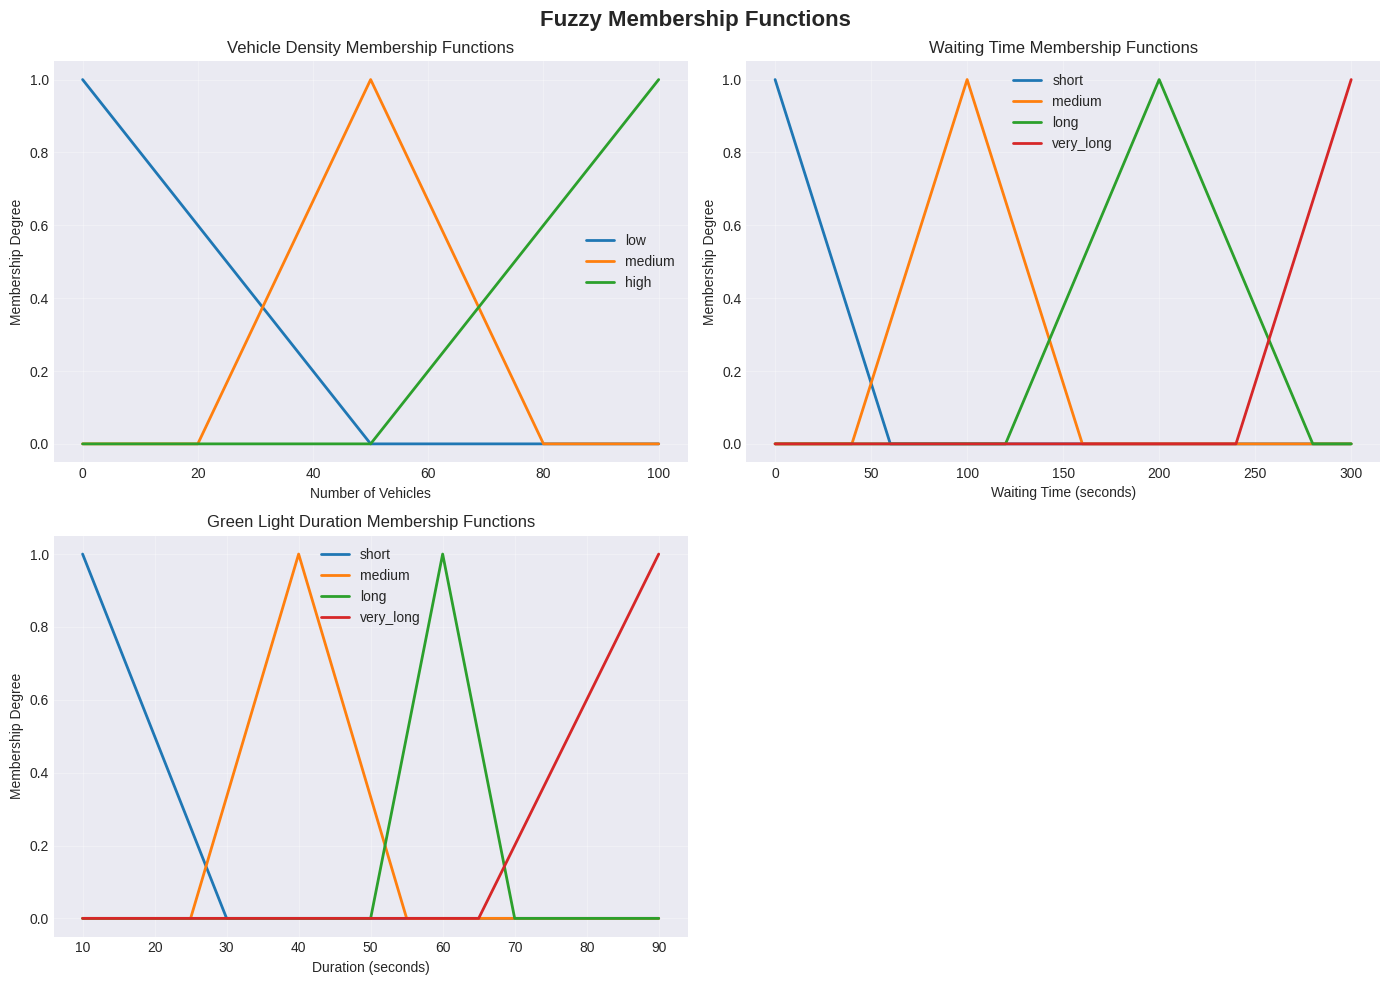

In [12]:
# Visualize membership functions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Fuzzy Membership Functions', fontsize=16, fontweight='bold')

# Plot density
ax = axes[0, 0]
density_north = antecedents['density_north']
for term in density_north.terms:
    ax.plot(density_north.universe, density_north[term].mf, label=term, linewidth=2)
ax.set_title('Vehicle Density Membership Functions')
ax.set_xlabel('Number of Vehicles')
ax.set_ylabel('Membership Degree')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot waiting time
ax = axes[0, 1]
waiting_north = antecedents['waiting_north']
for term in waiting_north.terms:
    ax.plot(waiting_north.universe, waiting_north[term].mf, label=term, linewidth=2)
ax.set_title('Waiting Time Membership Functions')
ax.set_xlabel('Waiting Time (seconds)')
ax.set_ylabel('Membership Degree')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot green time output
ax = axes[1, 0]
for term in green_time.terms:
    ax.plot(green_time.universe, green_time[term].mf, label=term, linewidth=2)
ax.set_title('Green Light Duration Membership Functions')
ax.set_xlabel('Duration (seconds)')
ax.set_ylabel('Membership Degree')
ax.legend()
ax.grid(True, alpha=0.3)

# Hide the last subplot
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

## 🧠 3. Fuzzy Rules
Implement 28 fuzzy rules covering:
1. **Primary density-based rules** (12 rules)
2. **Waiting time priority rules** (8 rules)
3. **Fairness and balance rules** (8 rules)

In [13]:
def create_fuzzy_rules(antecedents: Dict[str, ctrl.Antecedent],
                      consequent: ctrl.Consequent,
                      direction: str = 'north') -> List[ctrl.Rule]:
    """
    Create fuzzy rules for a specific traffic direction.

    Args:
        antecedents: Dictionary of input variables
        consequent: Output variable (green_time)
        direction: Traffic direction ('north', 'south', 'east', 'west')

    Returns:
        List of fuzzy rules for the specified direction
    """

    # Get direction-specific variables
    current_density = antecedents[f'density_{direction}']
    current_waiting = antecedents[f'waiting_{direction}']

    # Get opposite direction (for N-S or E-W axis)
    opposite_map = {
        'north': 'south',
        'south': 'north',
        'east': 'west',
        'west': 'east'
    }
    opposite_dir = opposite_map[direction]
    opposite_density = antecedents[f'density_{opposite_dir}']
    opposite_waiting = antecedents[f'waiting_{opposite_dir}']

    # Get perpendicular directions
    if direction in ['north', 'south']:
        perp_dir1, perp_dir2 = 'east', 'west'
    else:
        perp_dir1, perp_dir2 = 'north', 'south'

    perp_density1 = antecedents[f'density_{perp_dir1}']
    perp_density2 = antecedents[f'density_{perp_dir2}']
    perp_waiting1 = antecedents[f'waiting_{perp_dir1}']
    perp_waiting2 = antecedents[f'waiting_{perp_dir2}']

    rules = []

    # ========================================================================
    # CATEGORY 1: PRIMARY DENSITY-BASED RULES (12 rules)
    # ========================================================================

    # Rule 1: High current density + Low opposite density = Very Long green
    rules.append(ctrl.Rule(
        current_density['high'] & opposite_density['low'],
        consequent['very_long'],
        label=f'R1_{direction}_high_opp_low'
    ))

    # Rule 2: High current density + Medium opposite density = Long green
    rules.append(ctrl.Rule(
        current_density['high'] & opposite_density['medium'],
        consequent['long'],
        label=f'R2_{direction}_high_opp_med'
    ))

    # Rule 3: High current density + High opposite density = Medium green (balance)
    rules.append(ctrl.Rule(
        current_density['high'] & opposite_density['high'],
        consequent['medium'],
        label=f'R3_{direction}_high_opp_high'
    ))

    # Rule 4: Medium current density + Low opposite density = Long green
    rules.append(ctrl.Rule(
        current_density['medium'] & opposite_density['low'],
        consequent['long'],
        label=f'R4_{direction}_med_opp_low'
    ))

    # Rule 5: Medium current density + Medium opposite density = Medium green
    rules.append(ctrl.Rule(
        current_density['medium'] & opposite_density['medium'],
        consequent['medium'],
        label=f'R5_{direction}_med_opp_med'
    ))

    # Rule 6: Medium current density + High opposite density = Short green
    rules.append(ctrl.Rule(
        current_density['medium'] & opposite_density['high'],
        consequent['short'],
        label=f'R6_{direction}_med_opp_high'
    ))

    # Rule 7: Low current density + Low opposite density = Short green
    rules.append(ctrl.Rule(
        current_density['low'] & opposite_density['low'],
        consequent['short'],
        label=f'R7_{direction}_low_opp_low'
    ))

    # Rule 8: Low current density + Medium opposite density = Short green
    rules.append(ctrl.Rule(
        current_density['low'] & opposite_density['medium'],
        consequent['short'],
        label=f'R8_{direction}_low_opp_med'
    ))

    # Rule 9: Low current density + High opposite density = Short green
    rules.append(ctrl.Rule(
        current_density['low'] & opposite_density['high'],
        consequent['short'],
        label=f'R9_{direction}_low_opp_high'
    ))

    # Rule 10: High density regardless of opposite = at least Medium
    rules.append(ctrl.Rule(
        current_density['high'],
        consequent['medium'],
        label=f'R10_{direction}_high_minimum'
    ))

    # Rule 11: Medium current + Low opposite, but perpendicular is high = Medium (fairness)
    rules.append(ctrl.Rule(
        current_density['medium'] & opposite_density['low'] &
        (perp_density1['high'] | perp_density2['high']),
        consequent['medium'],
        label=f'R11_{direction}_fairness_perp'
    ))

    # Rule 12: Low density but very long waiting = Medium (prevent starvation)
    rules.append(ctrl.Rule(
        current_density['low'] & current_waiting['very_long'],
        consequent['medium'],
        label=f'R12_{direction}_starvation_prevent'
    ))

    # ========================================================================
    # CATEGORY 2: WAITING TIME PRIORITY RULES (8 rules)
    # ========================================================================

    # Rule 13: Very long waiting time = prioritize with Long green
    rules.append(ctrl.Rule(
        current_waiting['very_long'],
        consequent['long'],
        label=f'R13_{direction}_very_long_wait'
    ))

    # Rule 14: Long waiting + High density = Very Long green (emergency priority)
    rules.append(ctrl.Rule(
        current_waiting['long'] & current_density['high'],
        consequent['very_long'],
        label=f'R14_{direction}_long_wait_high_dens'
    ))

    # Rule 15: Long waiting + Medium density = Long green
    rules.append(ctrl.Rule(
        current_waiting['long'] & current_density['medium'],
        consequent['long'],
        label=f'R15_{direction}_long_wait_med_dens'
    ))

    # Rule 16: Medium waiting + Low density = Medium green
    rules.append(ctrl.Rule(
        current_waiting['medium'] & current_density['low'],
        consequent['medium'],
        label=f'R16_{direction}_med_wait_low_dens'
    ))

    # Rule 17: Short waiting + High density = Long green (density priority)
    rules.append(ctrl.Rule(
        current_waiting['short'] & current_density['high'],
        consequent['long'],
        label=f'R17_{direction}_short_wait_high_dens'
    ))

    # Rule 18: Current very long wait, but opposite also very long = Medium (fairness)
    rules.append(ctrl.Rule(
        current_waiting['very_long'] & opposite_waiting['very_long'],
        consequent['medium'],
        label=f'R18_{direction}_both_very_long_wait'
    ))

    # Rule 19: Long wait + perpendicular very long wait = Medium (global fairness)
    rules.append(ctrl.Rule(
        current_waiting['long'] &
        (perp_waiting1['very_long'] | perp_waiting2['very_long']),
        consequent['medium'],
        label=f'R19_{direction}_perp_very_long_wait'
    ))

    # Rule 20: Medium wait + all other directions short wait = Long green
    rules.append(ctrl.Rule(
        current_waiting['medium'] &
        opposite_waiting['short'] &
        perp_waiting1['short'] &
        perp_waiting2['short'],
        consequent['long'],
        label=f'R20_{direction}_only_waiting'
    ))

    # ========================================================================
    # CATEGORY 3: FAIRNESS AND BALANCE RULES (8 rules)
    # ========================================================================

    # Rule 21: High density everywhere = Medium green (rotate fairly)
    rules.append(ctrl.Rule(
        current_density['high'] &
        opposite_density['high'] &
        perp_density1['high'] &
        perp_density2['high'],
        consequent['medium'],
        label=f'R21_{direction}_all_high_dens'
    ))

    # Rule 22: Current high, all others low = Very Long (maximize throughput)
    rules.append(ctrl.Rule(
        current_density['high'] &
        opposite_density['low'] &
        perp_density1['low'] &
        perp_density2['low'],
        consequent['very_long'],
        label=f'R22_{direction}_only_high_dens'
    ))

    # Rule 23: Current medium, all others high = Short (give way)
    rules.append(ctrl.Rule(
        current_density['medium'] &
        opposite_density['high'] &
        perp_density1['high'] &
        perp_density2['high'],
        consequent['short'],
        label=f'R23_{direction}_give_way'
    ))

    # Rule 24: Balanced density everywhere = Medium green
    rules.append(ctrl.Rule(
        current_density['medium'] &
        opposite_density['medium'] &
        perp_density1['medium'] &
        perp_density2['medium'],
        consequent['medium'],
        label=f'R24_{direction}_balanced'
    ))

    # Rule 25: High current + High perpendicular = Medium (prevent cross-blocking)
    rules.append(ctrl.Rule(
        current_density['high'] &
        (perp_density1['high'] | perp_density2['high']),
        consequent['medium'],
        label=f'R25_{direction}_prevent_blocking'
    ))

    # Rule 26: Low current, high perpendicular waiting = Short (switch quickly)
    rules.append(ctrl.Rule(
        current_density['low'] &
        (perp_waiting1['long'] | perp_waiting2['long']),
        consequent['short'],
        label=f'R26_{direction}_quick_switch'
    ))

    # Rule 27: Medium density + opposite low + perpendicular medium = Long
    rules.append(ctrl.Rule(
        current_density['medium'] &
        opposite_density['low'] &
        perp_density1['medium'] &
        perp_density2['medium'],
        consequent['long'],
        label=f'R27_{direction}_opportunistic'
    ))

    # Rule 28: High wait + low density + opposite high density = Medium (balance)
    rules.append(ctrl.Rule(
        current_waiting['long'] &
        current_density['low'] &
        opposite_density['high'],
        consequent['medium'],
        label=f'R28_{direction}_wait_vs_density_balance'
    ))

    return rules


def create_all_fuzzy_rules(antecedents: Dict[str, ctrl.Antecedent],
                           consequent: ctrl.Consequent) -> Dict[str, List[ctrl.Rule]]:
    """Create fuzzy rules for all four directions."""
    all_rules = {}
    for direction in ['north', 'south', 'east', 'west']:
        all_rules[direction] = create_fuzzy_rules(antecedents, consequent, direction)
    return all_rules


# Create rules for all directions
all_rules = create_all_fuzzy_rules(antecedents, green_time)

print("✓ Fuzzy rules created successfully!")
print(f"  - Rules per direction: {len(all_rules['north'])}")
print(f"  - Total rules: {sum(len(r) for r in all_rules.values())}")
print("\nRule categories per direction:")
print("  • Primary Density Rules:    12 rules")
print("  • Waiting Time Rules:       8 rules")
print("  • Fairness & Balance Rules: 8 rules")

✓ Fuzzy rules created successfully!
  - Rules per direction: 28
  - Total rules: 112

Rule categories per direction:
  • Primary Density Rules:    12 rules
  • Waiting Time Rules:       8 rules
  • Fairness & Balance Rules: 8 rules


## 🎮 4. Fuzzy Traffic Controller
Main controller implementing Mamdani inference for traffic light control

In [14]:
class FuzzyTrafficController:
    """
    Fuzzy Logic Traffic Light Controller using Mamdani inference.

    Uses vehicle density and waiting time across all four directions
    to compute optimal green light duration for each direction.
    """

    def __init__(self, enable_logging: bool = False):
        """Initialize the fuzzy traffic controller."""
        self.logger = logging.getLogger(__name__)
        if enable_logging:
            logging.basicConfig(level=logging.INFO)

        # Create membership functions
        self.antecedents, self.consequent = create_membership_functions()

        # Create fuzzy rules for all directions
        self.all_rules = create_all_fuzzy_rules(self.antecedents, self.consequent)

        # Create control systems for each direction
        self.control_systems = {}
        self.controllers = {}

        for direction in ['north', 'south', 'east', 'west']:
            self.control_systems[direction] = ctrl.ControlSystem(self.all_rules[direction])
            self.controllers[direction] = ctrl.ControlSystemSimulation(
                self.control_systems[direction]
            )

    def compute_green_time(self, direction: str, traffic_state: Dict[str, Dict[str, float]]) -> float:
        """
        Compute optimal green light duration for a specific direction.

        Args:
            direction: Traffic direction ('north', 'south', 'east', 'west')
            traffic_state: Dictionary containing:
                - 'density': {direction: vehicle_count} for all 4 directions
                - 'waiting_time': {direction: seconds} for all 4 directions

        Returns:
            Optimal green light duration in seconds
        """
        if direction not in self.controllers:
            raise ValueError(f"Invalid direction: {direction}")

        controller = self.controllers[direction]

        # Set inputs for all directions
        for dir_name in ['north', 'south', 'east', 'west']:
            # Set density
            density_value = traffic_state['density'].get(dir_name, 0)
            controller.input[f'density_{dir_name}'] = np.clip(density_value, 0, 100)

            # Set waiting time
            waiting_value = traffic_state['waiting_time'].get(dir_name, 0)
            controller.input[f'waiting_{dir_name}'] = np.clip(waiting_value, 0, 300)

        # Compute output using Mamdani inference
        try:
            controller.compute()
            return controller.output['green_time']
        except Exception as e:
            # Return default medium green time on error
            return 40.0

    def compute_all_green_times(self, traffic_state: Dict[str, Dict[str, float]]) -> Dict[str, float]:
        """Compute green times for all four directions."""
        green_times = {}
        for direction in ['north', 'south', 'east', 'west']:
            green_times[direction] = self.compute_green_time(direction, traffic_state)
        return green_times


# Test the controller
print("Initializing Fuzzy Traffic Controller...")
fuzzy_controller = FuzzyTrafficController(enable_logging=False)
print("✓ Fuzzy Traffic Controller initialized!")

# Test with a sample traffic state
test_traffic_state = {
    'density': {'north': 75, 'south': 30, 'east': 50, 'west': 40},
    'waiting_time': {'north': 120, 'south': 45, 'east': 80, 'west': 60}
}

green_times = fuzzy_controller.compute_all_green_times(test_traffic_state)
print("\nTest computation - Green times for sample traffic:")
for direction, time in green_times.items():
    print(f"  {direction.capitalize():6s}: {time:5.1f}s")

Initializing Fuzzy Traffic Controller...
✓ Fuzzy Traffic Controller initialized!

Test computation - Green times for sample traffic:
  North :  57.3s
  South :  27.3s
  East  :  44.0s
  West  :  35.7s


## 🚗 5. Traffic Simulator
Queue-based traffic simulation model using Poisson arrival distribution

In [15]:
class LightState(Enum):
    """Traffic light states"""
    GREEN = "green"
    YELLOW = "yellow"
    RED = "red"


@dataclass
class Vehicle:
    """Represents a single vehicle in the system"""
    id: int
    arrival_time: float
    direction: str
    departed: bool = False
    departure_time: Optional[float] = None

    @property
    def waiting_time(self) -> float:
        """Calculate current waiting time"""
        if self.departed and self.departure_time:
            return self.departure_time - self.arrival_time
        return 0.0


@dataclass
class DirectionState:
    """State of traffic in one direction"""
    name: str
    queue: List[Vehicle] = field(default_factory=list)
    light_state: LightState = LightState.RED
    total_arrivals: int = 0
    total_departures: int = 0
    total_waiting_time: float = 0.0
    arrival_rate: float = 10.0
    recent_departures: List[Vehicle] = field(default_factory=list)

    @property
    def queue_length(self) -> int:
        return len(self.queue)


class TrafficSimulator:
    """
    Queue-based traffic simulator for a 4-way intersection.
    Uses Poisson arrival process and realistic departure during green lights.
    """

    def __init__(self, arrival_rates: Optional[Dict[str, float]] = None,
                 departure_rate: float = 0.5, simulation_duration: float = 3600,
                 random_seed: Optional[int] = None):
        """Initialize traffic simulator."""
        if random_seed is not None:
            np.random.seed(random_seed)

        self.directions = {}
        default_rates = {'north': 10, 'south': 10, 'east': 10, 'west': 10}
        rates = arrival_rates or default_rates

        for direction in ['north', 'south', 'east', 'west']:
            self.directions[direction] = DirectionState(
                name=direction,
                arrival_rate=rates.get(direction, 10.0)
            )

        self.departure_rate = departure_rate
        self.simulation_duration = simulation_duration
        self.current_time = 0.0
        self.vehicle_id_counter = 0
        self.total_vehicles_generated = 0
        self.total_vehicles_departed = 0

    def generate_arrivals(self, time_step: float = 1.0):
        """Generate vehicle arrivals using Poisson distribution."""
        for direction, state in self.directions.items():
            lambda_rate = state.arrival_rate / 60.0
            num_arrivals = np.random.poisson(lambda_rate * time_step)

            for _ in range(num_arrivals):
                vehicle = Vehicle(id=self.vehicle_id_counter,
                                arrival_time=self.current_time,
                                direction=direction)
                state.queue.append(vehicle)
                state.total_arrivals += 1
                self.vehicle_id_counter += 1
                self.total_vehicles_generated += 1

    def process_departures(self, time_step: float = 1.0):
        """Process vehicle departures for directions with green lights."""
        for state in self.directions.values():
            state.recent_departures.clear()

        for direction, state in self.directions.items():
            if state.light_state != LightState.GREEN:
                continue

            max_departures = int(time_step / self.departure_rate)
            departures_count = 0

            while state.queue and departures_count < max_departures:
                vehicle = state.queue.pop(0)
                vehicle.departed = True
                vehicle.departure_time = self.current_time

                waiting_time = vehicle.waiting_time
                state.total_waiting_time += waiting_time
                state.total_departures += 1
                state.recent_departures.append(vehicle)
                self.total_vehicles_departed += 1
                departures_count += 1

    def set_light_state(self, direction: str, state: LightState):
        """Set traffic light state for a direction."""
        self.directions[direction].light_state = state

    def set_all_lights(self, states: Dict[str, LightState]):
        """Set light states for all directions."""
        for direction, state in states.items():
            self.set_light_state(direction, state)

    def step(self, time_step: float = 1.0):
        """Advance simulation by one time step."""
        self.generate_arrivals(time_step)
        self.process_departures(time_step)
        self.current_time += time_step

    def get_traffic_state(self) -> Dict[str, Dict[str, float]]:
        """Get current traffic state for fuzzy controller input."""
        traffic_state = {'density': {}, 'waiting_time': {}}

        for direction, state in self.directions.items():
            traffic_state['density'][direction] = min(state.queue_length * 2, 100)

            if state.queue:
                waiting = self.current_time - state.queue[0].arrival_time
                traffic_state['waiting_time'][direction] = min(waiting, 300)
            else:
                traffic_state['waiting_time'][direction] = 0.0

        return traffic_state

    def get_statistics(self) -> Dict:
        """Get simulation statistics."""
        stats = {
            'simulation_time': self.current_time,
            'total_arrivals': self.total_vehicles_generated,
            'total_departures': self.total_vehicles_departed,
            'vehicles_in_system': self.total_vehicles_generated - self.total_vehicles_departed,
            'directions': {}
        }

        for direction, state in self.directions.items():
            stats['directions'][direction] = {
                'arrivals': state.total_arrivals,
                'departures': state.total_departures,
                'current_queue_length': state.queue_length,
                'average_waiting_time': (
                    state.total_waiting_time / state.total_departures
                    if state.total_departures > 0 else 0
                )
            }

        return stats


print("✓ Traffic Simulator class created!")

✓ Traffic Simulator class created!


## 📊 6. Performance Metrics & Fixed Controller
Metrics calculator and fixed-time baseline controller for comparison

In [16]:
# Performance Metrics
@dataclass
class DirectionMetrics:
    """Performance metrics for one direction"""
    direction: str
    total_arrivals: int = 0
    total_departures: int = 0
    waiting_times: List[float] = field(default_factory=list)
    queue_lengths: List[int] = field(default_factory=list)

    @property
    def average_waiting_time(self) -> float:
        return np.mean(self.waiting_times) if self.waiting_times else 0.0

    @property
    def max_waiting_time(self) -> float:
        return max(self.waiting_times) if self.waiting_times else 0.0

    @property
    def average_queue_length(self) -> float:
        return np.mean(self.queue_lengths) if self.queue_lengths else 0.0

    @property
    def max_queue_length(self) -> int:
        return max(self.queue_lengths) if self.queue_lengths else 0


class PerformanceMetrics:
    """Comprehensive performance metrics for traffic control evaluation."""

    def __init__(self, simulation_duration: float = 3600):
        self.simulation_duration = simulation_duration
        self.directions: Dict[str, DirectionMetrics] = {
            'north': DirectionMetrics('north'),
            'south': DirectionMetrics('south'),
            'east': DirectionMetrics('east'),
            'west': DirectionMetrics('west')
        }
        self.timestamps: List[float] = []
        self.total_queue_history: List[int] = []

    def record_timestep(self, timestamp: float, traffic_state: Dict):
        """Record metrics for a single timestep."""
        self.timestamps.append(timestamp)
        total_queue = 0

        for direction in ['north', 'south', 'east', 'west']:
            dir_metrics = self.directions[direction]
            if 'queue_lengths' in traffic_state:
                queue_len = traffic_state['queue_lengths'].get(direction, 0)
                dir_metrics.queue_lengths.append(queue_len)
                total_queue += queue_len

        self.total_queue_history.append(total_queue)

    def record_departure(self, direction: str, waiting_time: float):
        """Record a vehicle departure."""
        self.directions[direction].waiting_times.append(waiting_time)
        self.directions[direction].total_departures += 1

    @property
    def average_waiting_time(self) -> float:
        all_waiting_times = []
        for dir_metrics in self.directions.values():
            all_waiting_times.extend(dir_metrics.waiting_times)
        return np.mean(all_waiting_times) if all_waiting_times else 0.0

    @property
    def max_waiting_time(self) -> float:
        max_times = [d.max_waiting_time for d in self.directions.values()]
        return max(max_times) if max_times else 0.0

    @property
    def average_queue_length(self) -> float:
        return np.mean(self.total_queue_history) if self.total_queue_history else 0.0

    @property
    def max_queue_length(self) -> int:
        return max(self.total_queue_history) if self.total_queue_history else 0

    @property
    def throughput_per_hour(self) -> float:
        total_departures = sum(d.total_departures for d in self.directions.values())
        hours = self.simulation_duration / 3600
        return total_departures / hours if hours > 0 else 0.0

    @property
    def fairness_index(self) -> float:
        """Jain's Fairness Index (1 = perfectly fair)."""
        avg_waiting_times = [d.average_waiting_time for d in self.directions.values()
                            if d.total_departures > 0]

        if not avg_waiting_times or len(avg_waiting_times) < 2:
            return 1.0

        n = len(avg_waiting_times)
        sum_x = sum(avg_waiting_times)
        sum_x_squared = sum(x**2 for x in avg_waiting_times)

        if sum_x_squared == 0:
            return 1.0

        return (sum_x ** 2) / (n * sum_x_squared)

    def get_summary(self) -> Dict:
        """Get comprehensive summary of all metrics."""
        return {
            'average_waiting_time': self.average_waiting_time,
            'max_waiting_time': self.max_waiting_time,
            'average_queue_length': self.average_queue_length,
            'max_queue_length': self.max_queue_length,
            'throughput_per_hour': self.throughput_per_hour,
            'fairness_index': self.fairness_index
        }

    def compare_with(self, other: 'PerformanceMetrics') -> Dict:
        """Compare metrics with another controller's performance."""
        return {
            'waiting_time_improvement_%': (
                (other.average_waiting_time - self.average_waiting_time) /
                other.average_waiting_time * 100
                if other.average_waiting_time > 0 else 0
            ),
            'queue_length_improvement_%': (
                (other.average_queue_length - self.average_queue_length) /
                other.average_queue_length * 100
                if other.average_queue_length > 0 else 0
            ),
            'throughput_improvement_%': (
                (self.throughput_per_hour - other.throughput_per_hour) /
                other.throughput_per_hour * 100
                if other.throughput_per_hour > 0 else 0
            ),
            'fairness_improvement': self.fairness_index - other.fairness_index
        }


# Fixed-Time Controller
@dataclass
class FixedPhase:
    name: str
    duration: float
    north_state: str
    south_state: str
    east_state: str
    west_state: str


class FixedTimeController:
    """Traditional fixed-time traffic light controller."""

    def __init__(self, ns_green: float = 40.0, ew_green: float = 40.0,
                 yellow_time: float = 3.0, all_red_time: float = 2.0):
        self.ns_green = ns_green
        self.ew_green = ew_green
        self.yellow_time = yellow_time
        self.all_red_time = all_red_time
        self.phases = self._build_cycle()
        self.cycle_duration = sum(phase.duration for phase in self.phases)
        self.current_phase_index = 0
        self.time_in_current_phase = 0.0

    def _build_cycle(self) -> List[FixedPhase]:
        return [
            FixedPhase("NS_GREEN", self.ns_green, "green", "green", "red", "red"),
            FixedPhase("NS_YELLOW", self.yellow_time, "yellow", "yellow", "red", "red"),
            FixedPhase("ALL_RED_1", self.all_red_time, "red", "red", "red", "red"),
            FixedPhase("EW_GREEN", self.ew_green, "red", "red", "green", "green"),
            FixedPhase("EW_YELLOW", self.yellow_time, "red", "red", "yellow", "yellow"),
            FixedPhase("ALL_RED_2", self.all_red_time, "red", "red", "red", "red")
        ]

    def get_current_phase(self) -> FixedPhase:
        return self.phases[self.current_phase_index]

    def get_light_states(self) -> Dict[str, str]:
        phase = self.get_current_phase()
        return {
            'north': phase.north_state,
            'south': phase.south_state,
            'east': phase.east_state,
            'west': phase.west_state
        }

    def step(self, time_step: float = 1.0):
        self.time_in_current_phase += time_step
        current_phase = self.get_current_phase()

        if self.time_in_current_phase >= current_phase.duration:
            self.current_phase_index = (self.current_phase_index + 1) % len(self.phases)
            self.time_in_current_phase = 0.0


print("✓ Performance Metrics and Fixed Controller classes created!")

✓ Performance Metrics and Fixed Controller classes created!


## 🎬 7. Traffic Scenarios
Define various traffic patterns for testing

In [17]:
@dataclass
class TrafficScenario:
    """Defines a traffic scenario with arrival rates"""
    name: str
    description: str
    arrival_rates: Dict[str, float]  # vehicles per minute
    duration: float = 1800  # seconds (30 minutes for quick demo)


# Define scenarios
scenarios = {
    'normal': TrafficScenario(
        name="Normal Traffic",
        description="Balanced traffic with moderate flow",
        arrival_rates={'north': 12, 'south': 12, 'east': 12, 'west': 12}
    ),
    'rush_ns': TrafficScenario(
        name="Rush Hour (N-S)",
        description="Heavy North-South traffic",
        arrival_rates={'north': 35, 'south': 35, 'east': 10, 'west': 10}
    ),
    'rush_ew': TrafficScenario(
        name="Rush Hour (E-W)",
        description="Heavy East-West traffic",
        arrival_rates={'north': 10, 'south': 10, 'east': 35, 'west': 35}
    ),
    'light': TrafficScenario(
        name="Light Traffic",
        description="Light traffic (late night)",
        arrival_rates={'north': 5, 'south': 5, 'east': 5, 'west': 5}
    )
}

print("✓ Traffic scenarios defined:")
for key, scenario in scenarios.items():
    print(f"  - {scenario.name}: {scenario.description}")

✓ Traffic scenarios defined:
  - Normal Traffic: Balanced traffic with moderate flow
  - Rush Hour (N-S): Heavy North-South traffic
  - Rush Hour (E-W): Heavy East-West traffic
  - Light Traffic: Light traffic (late night)


## 🚀 8. Run Simulation Functions
Functions to run simulation with both controllers

In [18]:
def run_simulation_with_fuzzy(scenario: TrafficScenario, duration: float = 1800) -> PerformanceMetrics:
    """
    Run simulation with fuzzy controller.

    Args:
        scenario: TrafficScenario object
        duration: Simulation duration in seconds

    Returns:
        PerformanceMetrics object
    """
    # Initialize
    simulator = TrafficSimulator(
        arrival_rates=scenario.arrival_rates,
        simulation_duration=duration,
        random_seed=42
    )
    controller = FuzzyTrafficController(enable_logging=False)
    metrics = PerformanceMetrics(simulation_duration=duration)

    time_step = 1.0
    current_phase = 'init'
    phase_start_time = 0.0
    phase_duration = 0.0

    while simulator.current_time < duration:
        traffic_state = simulator.get_traffic_state()

        # Record metrics
        queue_state = {
            'queue_lengths': {d: simulator.directions[d].queue_length
                            for d in ['north', 'south', 'east', 'west']}
        }
        metrics.record_timestep(simulator.current_time, queue_state)

        # Phase management
        time_in_phase = simulator.current_time - phase_start_time

        if time_in_phase >= phase_duration:
            if current_phase == 'init':
                ns_green = (controller.compute_green_time('north', traffic_state) +
                           controller.compute_green_time('south', traffic_state)) / 2
                phase_duration = ns_green
                phase_start_time = simulator.current_time
                current_phase = 'ns_green'
                simulator.set_all_lights({
                    'north': LightState.GREEN, 'south': LightState.GREEN,
                    'east': LightState.RED, 'west': LightState.RED
                })
            elif current_phase == 'ns_green':
                phase_duration = 3.0
                phase_start_time = simulator.current_time
                current_phase = 'ns_yellow'
                simulator.set_all_lights({
                    'north': LightState.YELLOW, 'south': LightState.YELLOW,
                    'east': LightState.RED, 'west': LightState.RED
                })
            elif current_phase == 'ns_yellow':
                phase_duration = 2.0
                phase_start_time = simulator.current_time
                current_phase = 'all_red_1'
                simulator.set_all_lights({
                    d: LightState.RED for d in ['north', 'south', 'east', 'west']
                })
            elif current_phase == 'all_red_1':
                ew_green = (controller.compute_green_time('east', traffic_state) +
                           controller.compute_green_time('west', traffic_state)) / 2
                phase_duration = ew_green
                phase_start_time = simulator.current_time
                current_phase = 'ew_green'
                simulator.set_all_lights({
                    'north': LightState.RED, 'south': LightState.RED,
                    'east': LightState.GREEN, 'west': LightState.GREEN
                })
            elif current_phase == 'ew_green':
                phase_duration = 3.0
                phase_start_time = simulator.current_time
                current_phase = 'ew_yellow'
                simulator.set_all_lights({
                    'north': LightState.RED, 'south': LightState.RED,
                    'east': LightState.YELLOW, 'west': LightState.YELLOW
                })
            elif current_phase == 'ew_yellow':
                phase_duration = 2.0
                phase_start_time = simulator.current_time
                current_phase = 'all_red_2'
                simulator.set_all_lights({
                    d: LightState.RED for d in ['north', 'south', 'east', 'west']
                })
            elif current_phase == 'all_red_2':
                ns_green = (controller.compute_green_time('north', traffic_state) +
                           controller.compute_green_time('south', traffic_state)) / 2
                phase_duration = ns_green
                phase_start_time = simulator.current_time
                current_phase = 'ns_green'
                simulator.set_all_lights({
                    'north': LightState.GREEN, 'south': LightState.GREEN,
                    'east': LightState.RED, 'west': LightState.RED
                })

        # Step simulation
        simulator.step(time_step)

        # Record departures
        for direction, dir_state in simulator.directions.items():
            for vehicle in dir_state.recent_departures:
                metrics.record_departure(direction, vehicle.waiting_time)

    return metrics


def run_simulation_with_fixed(scenario: TrafficScenario, duration: float = 1800) -> PerformanceMetrics:
    """
    Run simulation with fixed-time controller.
    """
    simulator = TrafficSimulator(
        arrival_rates=scenario.arrival_rates,
        simulation_duration=duration,
        random_seed=42
    )
    controller = FixedTimeController(ns_green=40, ew_green=40,
                                     yellow_time=3, all_red_time=2)
    metrics = PerformanceMetrics(simulation_duration=duration)

    time_step = 1.0

    while simulator.current_time < duration:
        light_states = controller.get_light_states()

        for direction, state_str in light_states.items():
            simulator.set_light_state(direction, LightState(state_str))

        queue_state = {
            'queue_lengths': {d: simulator.directions[d].queue_length
                            for d in ['north', 'south', 'east', 'west']}
        }
        metrics.record_timestep(simulator.current_time, queue_state)

        simulator.step(time_step)
        controller.step(time_step)

        for direction, dir_state in simulator.directions.items():
            for vehicle in dir_state.recent_departures:
                metrics.record_departure(direction, vehicle.waiting_time)

    return metrics


print("✓ Simulation functions ready!")

✓ Simulation functions ready!


## 📊 9. Run Comparison & Visualize Results
Compare Fuzzy vs Fixed-Time controllers and visualize results

In [19]:
# Select scenario to test (change this to test different scenarios)
SCENARIO_KEY = 'normal'  # Options: 'normal', 'rush_ns', 'rush_ew', 'light'
scenario = scenarios[SCENARIO_KEY]

print("=" * 70)
print(f"RUNNING SIMULATION: {scenario.name}")
print("=" * 70)
print(f"Description: {scenario.description}")
print(f"Duration: {scenario.duration}s ({scenario.duration/60:.1f} minutes)")
print(f"Arrival rates: {scenario.arrival_rates}")
print()

# Run with Fuzzy Controller
print("Running with Fuzzy Controller...")
fuzzy_metrics = run_simulation_with_fuzzy(scenario, duration=scenario.duration)
print("✓ Fuzzy simulation complete")

# Run with Fixed-Time Controller
print("Running with Fixed-Time Controller...")
fixed_metrics = run_simulation_with_fixed(scenario, duration=scenario.duration)
print("✓ Fixed-time simulation complete")
print()

# Get results
fuzzy_summary = fuzzy_metrics.get_summary()
fixed_summary = fixed_metrics.get_summary()
comparison = fuzzy_metrics.compare_with(fixed_metrics)

# Print results
print("=" * 70)
print("RESULTS COMPARISON")
print("=" * 70)
print("\nFUZZY CONTROLLER:")
print(f"  Avg Waiting Time:     {fuzzy_summary['average_waiting_time']:.2f}s")
print(f"  Max Waiting Time:     {fuzzy_summary['max_waiting_time']:.2f}s")
print(f"  Avg Queue Length:     {fuzzy_summary['average_queue_length']:.2f}")
print(f"  Max Queue Length:     {fuzzy_summary['max_queue_length']}")
print(f"  Throughput:           {fuzzy_summary['throughput_per_hour']:.1f} veh/h")
print(f"  Fairness Index:       {fuzzy_summary['fairness_index']:.3f}")

print("\nFIXED-TIME CONTROLLER:")
print(f"  Avg Waiting Time:     {fixed_summary['average_waiting_time']:.2f}s")
print(f"  Max Waiting Time:     {fixed_summary['max_waiting_time']:.2f}s")
print(f"  Avg Queue Length:     {fixed_summary['average_queue_length']:.2f}")
print(f"  Max Queue Length:     {fixed_summary['max_queue_length']}")
print(f"  Throughput:           {fixed_summary['throughput_per_hour']:.1f} veh/h")
print(f"  Fairness Index:       {fixed_summary['fairness_index']:.3f}")

print("\nIMPROVEMENT (Fuzzy vs Fixed):")
print(f"  Waiting Time:    {comparison['waiting_time_improvement_%']:+.1f}%")
print(f"  Queue Length:    {comparison['queue_length_improvement_%']:+.1f}%")
print(f"  Throughput:      {comparison['throughput_improvement_%']:+.1f}%")
print(f"  Fairness:        {comparison['fairness_improvement']:+.3f}")
print("=" * 70)

RUNNING SIMULATION: Normal Traffic
Description: Balanced traffic with moderate flow
Duration: 1800s (30.0 minutes)
Arrival rates: {'north': 12, 'south': 12, 'east': 12, 'west': 12}

Running with Fuzzy Controller...
✓ Fuzzy simulation complete
Running with Fixed-Time Controller...
✓ Fixed-time simulation complete

RESULTS COMPARISON

FUZZY CONTROLLER:
  Avg Waiting Time:     9.81s
  Max Waiting Time:     35.00s
  Avg Queue Length:     7.62
  Max Queue Length:     21
  Throughput:           2784.0 veh/h
  Fairness Index:       1.000

FIXED-TIME CONTROLLER:
  Avg Waiting Time:     15.69s
  Max Waiting Time:     50.00s
  Avg Queue Length:     12.26
  Max Queue Length:     33
  Throughput:           2752.0 veh/h
  Fairness Index:       0.998

IMPROVEMENT (Fuzzy vs Fixed):
  Waiting Time:    +37.5%
  Queue Length:    +37.8%
  Throughput:      +1.2%
  Fairness:        +0.001


### Visualization: Performance Comparison Charts

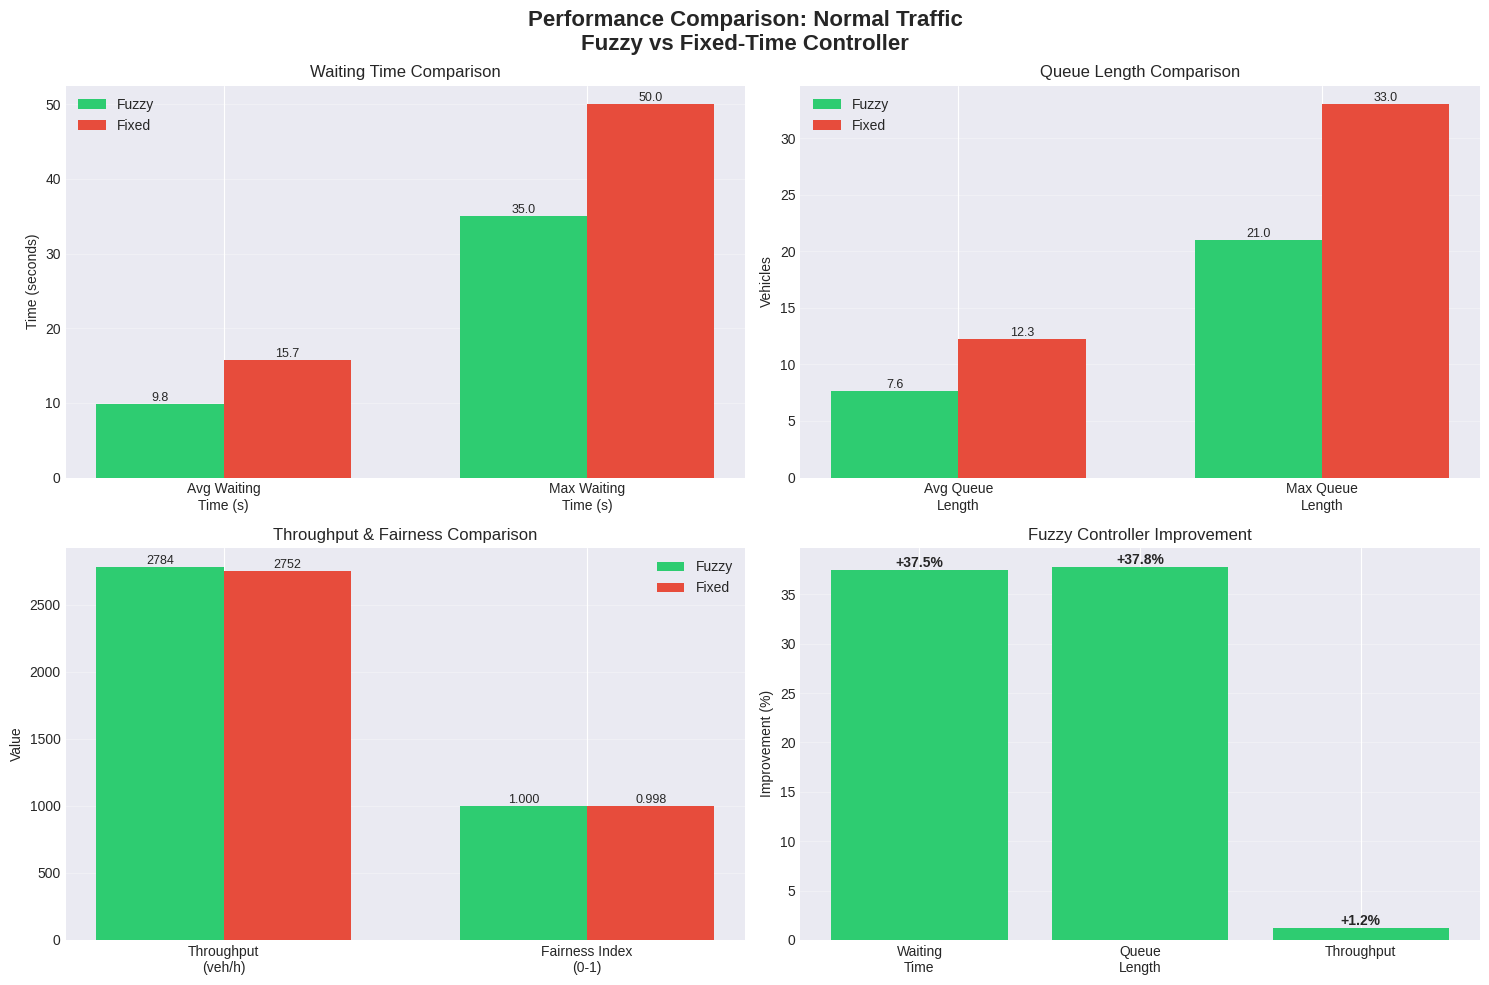

In [20]:
# Create comparison charts
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(f'Performance Comparison: {scenario.name}\nFuzzy vs Fixed-Time Controller',
             fontsize=16, fontweight='bold')

# 1. Waiting Time Comparison
ax = axes[0, 0]
metrics_names = ['Avg Waiting\nTime (s)', 'Max Waiting\nTime (s)']
fuzzy_values = [fuzzy_summary['average_waiting_time'], fuzzy_summary['max_waiting_time']]
fixed_values = [fixed_summary['average_waiting_time'], fixed_summary['max_waiting_time']]

x = np.arange(len(metrics_names))
width = 0.35

bars1 = ax.bar(x - width/2, fuzzy_values, width, label='Fuzzy', color='#2ecc71')
bars2 = ax.bar(x + width/2, fixed_values, width, label='Fixed', color='#e74c3c')

ax.set_ylabel('Time (seconds)')
ax.set_title('Waiting Time Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=9)

# 2. Queue Length Comparison
ax = axes[0, 1]
metrics_names = ['Avg Queue\nLength', 'Max Queue\nLength']
fuzzy_values = [fuzzy_summary['average_queue_length'], fuzzy_summary['max_queue_length']]
fixed_values = [fixed_summary['average_queue_length'], fixed_summary['max_queue_length']]

bars1 = ax.bar(x - width/2, fuzzy_values, width, label='Fuzzy', color='#2ecc71')
bars2 = ax.bar(x + width/2, fixed_values, width, label='Fixed', color='#e74c3c')

ax.set_ylabel('Vehicles')
ax.set_title('Queue Length Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=9)

# 3. Throughput & Fairness
ax = axes[1, 0]
metrics_names = ['Throughput\n(veh/h)', 'Fairness Index\n(0-1)']
fuzzy_values = [fuzzy_summary['throughput_per_hour'], fuzzy_summary['fairness_index'] * 1000]  # Scale fairness for visibility
fixed_values = [fixed_summary['throughput_per_hour'], fixed_summary['fairness_index'] * 1000]

bars1 = ax.bar(x - width/2, fuzzy_values, width, label='Fuzzy', color='#2ecc71')
bars2 = ax.bar(x + width/2, fixed_values, width, label='Fixed', color='#e74c3c')

ax.set_ylabel('Value')
ax.set_title('Throughput & Fairness Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add labels (undo scaling for fairness)
for i, bars in enumerate([bars1, bars2]):
    for j, bar in enumerate(bars):
        height = bar.get_height()
        if j == 1:  # Fairness index
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height/1000:.3f}', ha='center', va='bottom', fontsize=9)
        else:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.0f}', ha='center', va='bottom', fontsize=9)

# 4. Improvement Percentages
ax = axes[1, 1]
improvement_names = ['Waiting\nTime', 'Queue\nLength', 'Throughput']
improvement_values = [
    comparison['waiting_time_improvement_%'],
    comparison['queue_length_improvement_%'],
    comparison['throughput_improvement_%']
]

colors = ['#2ecc71' if v > 0 else '#e74c3c' for v in improvement_values]
bars = ax.bar(improvement_names, improvement_values, color=colors)

ax.set_ylabel('Improvement (%)')
ax.set_title('Fuzzy Controller Improvement')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:+.1f}%', ha='center',
            va='bottom' if height > 0 else 'top', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

### Queue Length Over Time Visualization

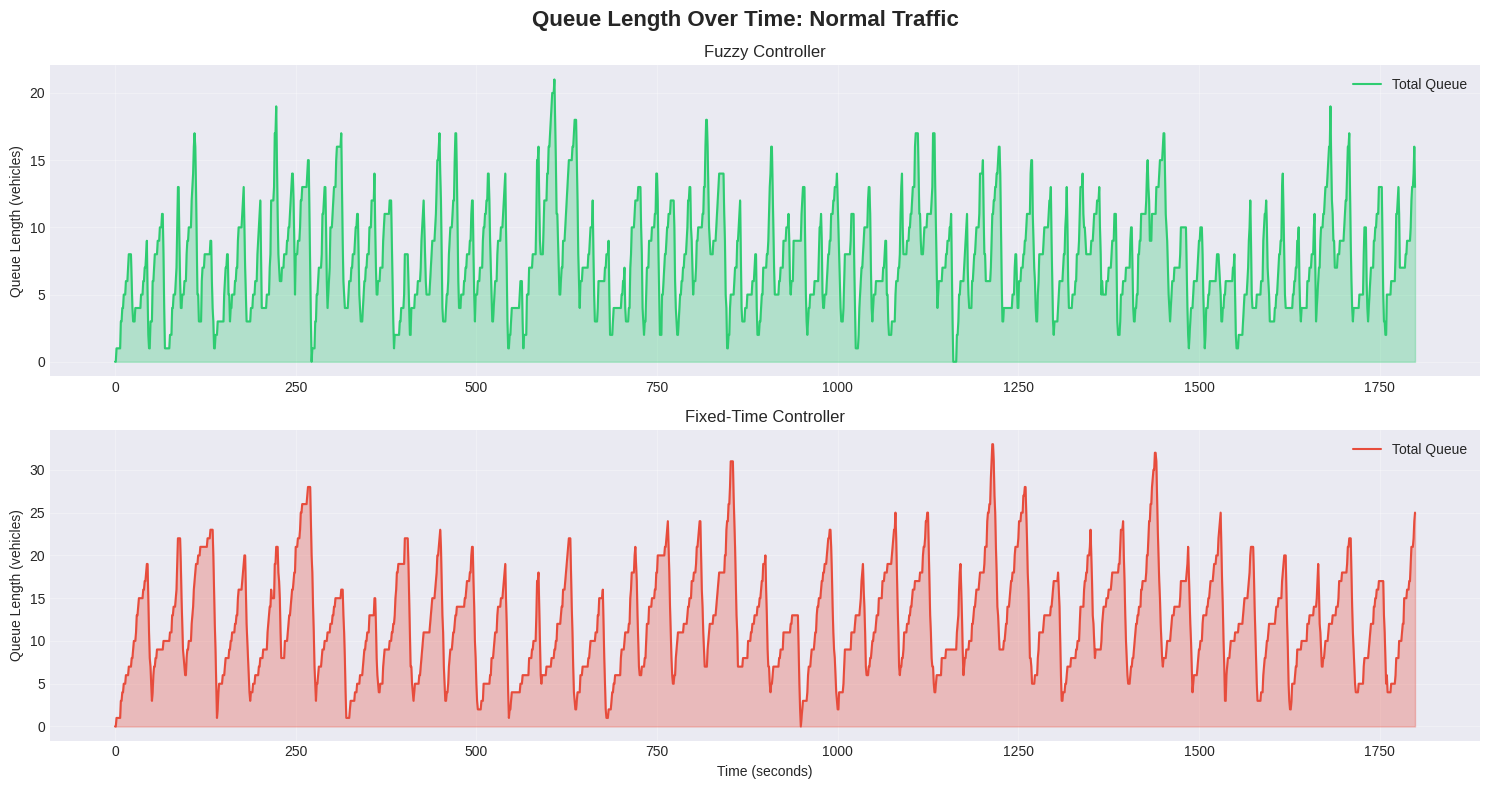


✓ Average queue reduction: 37.8%


In [21]:
# Plot queue length over time
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
fig.suptitle(f'Queue Length Over Time: {scenario.name}', fontsize=16, fontweight='bold')

# Fuzzy Controller
ax1.plot(fuzzy_metrics.timestamps, fuzzy_metrics.total_queue_history,
         color='#2ecc71', linewidth=1.5, label='Total Queue')
ax1.set_ylabel('Queue Length (vehicles)')
ax1.set_title('Fuzzy Controller')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.fill_between(fuzzy_metrics.timestamps, fuzzy_metrics.total_queue_history,
                  alpha=0.3, color='#2ecc71')

# Fixed Controller
ax2.plot(fixed_metrics.timestamps, fixed_metrics.total_queue_history,
         color='#e74c3c', linewidth=1.5, label='Total Queue')
ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('Queue Length (vehicles)')
ax2.set_title('Fixed-Time Controller')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.fill_between(fixed_metrics.timestamps, fixed_metrics.total_queue_history,
                  alpha=0.3, color='#e74c3c')

plt.tight_layout()
plt.show()

print(f"\n✓ Average queue reduction: {comparison['queue_length_improvement_%']:.1f}%")

## 🔄 10. Run Multiple Scenarios (Optional)
Compare all scenarios at once

In [22]:
# Run all scenarios and collect results
print("Running all scenarios...\n")
all_results = {}

for key, scenario in scenarios.items():
    print(f"Testing {scenario.name}...")

    fuzzy_metrics = run_simulation_with_fuzzy(scenario, duration=min(scenario.duration, 900))  # 15 min max
    fixed_metrics = run_simulation_with_fixed(scenario, duration=min(scenario.duration, 900))

    fuzzy_summary = fuzzy_metrics.get_summary()
    fixed_summary = fixed_metrics.get_summary()
    comparison = fuzzy_metrics.compare_with(fixed_metrics)

    all_results[key] = {
        'scenario': scenario,
        'fuzzy': fuzzy_summary,
        'fixed': fixed_summary,
        'comparison': comparison
    }

    print(f"  Improvement: {comparison['waiting_time_improvement_%']:+.1f}%\n")

print("✓ All scenarios completed!")

Running all scenarios...

Testing Normal Traffic...
  Improvement: +33.8%

Testing Rush Hour (N-S)...
  Improvement: +26.9%

Testing Rush Hour (E-W)...
  Improvement: +28.4%

Testing Light Traffic...
  Improvement: +42.5%

✓ All scenarios completed!


### Summary Comparison Across All Scenarios

In [23]:
# Create summary comparison table
summary_data = []

for key, result in all_results.items():
    summary_data.append({
        'Scenario': result['scenario'].name,
        'Fuzzy Avg Wait (s)': f"{result['fuzzy']['average_waiting_time']:.2f}",
        'Fixed Avg Wait (s)': f"{result['fixed']['average_waiting_time']:.2f}",
        'Improvement (%)': f"{result['comparison']['waiting_time_improvement_%']:+.1f}%",
        'Fuzzy Throughput': f"{result['fuzzy']['throughput_per_hour']:.0f}",
        'Fixed Throughput': f"{result['fixed']['throughput_per_hour']:.0f}"
    })

df = pd.DataFrame(summary_data)
print("\n" + "=" * 100)
print("SUMMARY: ALL SCENARIOS COMPARISON")
print("=" * 100)
print(df.to_string(index=False))
print("=" * 100)


SUMMARY: ALL SCENARIOS COMPARISON
       Scenario Fuzzy Avg Wait (s) Fixed Avg Wait (s) Improvement (%) Fuzzy Throughput Fixed Throughput
 Normal Traffic               9.94              15.01          +33.8%             2724             2672
Rush Hour (N-S)              13.16              18.00          +26.9%             5348             5244
Rush Hour (E-W)              13.83              19.32          +28.4%             5436             5348
  Light Traffic               8.65              15.05          +42.5%             1180             1152


### Comparative Bar Chart - All Scenarios

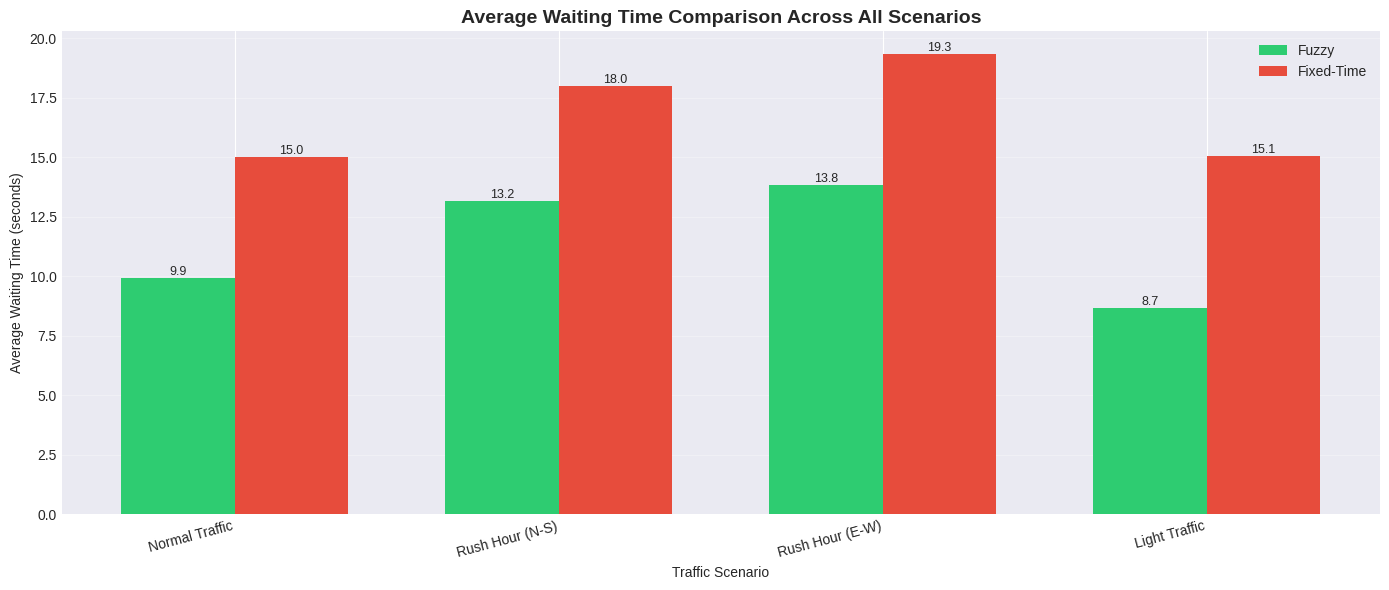

In [24]:
# Visualization: All scenarios comparison
fig, ax = plt.subplots(figsize=(14, 6))

scenario_names = [result['scenario'].name for result in all_results.values()]
fuzzy_wait_times = [result['fuzzy']['average_waiting_time'] for result in all_results.values()]
fixed_wait_times = [result['fixed']['average_waiting_time'] for result in all_results.values()]

x = np.arange(len(scenario_names))
width = 0.35

bars1 = ax.bar(x - width/2, fuzzy_wait_times, width, label='Fuzzy', color='#2ecc71')
bars2 = ax.bar(x + width/2, fixed_wait_times, width, label='Fixed-Time', color='#e74c3c')

ax.set_xlabel('Traffic Scenario')
ax.set_ylabel('Average Waiting Time (seconds)')
ax.set_title('Average Waiting Time Comparison Across All Scenarios', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(scenario_names, rotation=15, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()